# Twitter Webscraping - python

## 1. Importación de librerias y dependencias

In [1]:
import csv
from getpass import getpass
from time import sleep

import pandas as pd

from selenium.webdriver.common.keys import Keys
from selenium.common.exceptions import NoSuchElementException
from selenium import webdriver
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--start-maximized')
#chrome_options.add_argument('--incognito')
chrome_options.add_argument('--headless')
driver =webdriver.Chrome('chromedriver', options=chrome_options)


**Funcion principal**

In [2]:
def get_tweet_data(card):
    """Extract data from tweet card"""
    username = card.find_element_by_xpath('.//span').text
    try:
        handle = card.find_element_by_xpath('.//span[contains(text(), "@")]').text
    except NoSuchElementException:
        return
    
    try:
        postdate = card.find_element_by_xpath('.//time').get_attribute('datetime')
    except NoSuchElementException:
        return
    
    comment = card.find_element_by_xpath('.//div[2]/div[2]/div[1]').text
    responding = card.find_element_by_xpath('.//div[2]/div[2]/div[2]').text
    text = comment + responding
    reply_cnt = card.find_element_by_xpath('.//div[@data-testid="reply"]').text
    retweet_cnt = card.find_element_by_xpath('.//div[@data-testid="retweet"]').text
    like_cnt = card.find_element_by_xpath('.//div[@data-testid="like"]').text
    
    # get a string of all emojis contained in the tweet
    """Emojis are stored as images... so I convert the filename, which is stored as unicode, into 
    the emoji character."""
    emoji_tags = card.find_elements_by_xpath('.//img[contains(@src, "emoji")]')
    emoji_list = []
    for tag in emoji_tags:
        filename = tag.get_attribute('src')
        try:
            emoji = chr(int(re.search(r'svg\/([a-z0-9]+)\.svg', filename).group(1), base=16))
        except AttributeError:
            continue
        if emoji:
            emoji_list.append(emoji)
    emojis = ' '.join(emoji_list)
    
    tweet = (username, handle, postdate, text, emojis, reply_cnt, retweet_cnt, like_cnt)
    return tweet

**Autentificación**

In [3]:
driver.get('https://www.twitter.com/login')
sleep(1)
username = driver.find_element_by_xpath('//input[@name="session[username_or_email]"]')
username.send_keys('971090304')
#pln_user
password = 'pln_user'
my_password = getpass(password)
password = driver.find_element_by_xpath('//input[@name="session[password]"]')
password.send_keys(my_password)

password.send_keys(Keys.RETURN)
sleep(1)


pln_user ········


**Tendencias para Perú**

In [4]:
driver.find_element_by_xpath('//a[@href="/explore"]').click()
sleep(2)
list_trends = driver.find_elements_by_xpath('//div[@data-testid="trend"]')
list_trend = []
for trend in list_trends:
    if trend.find_element_by_xpath('.//div[1]/div[1]').text == "Trending in Peru":
        list_trend.append(trend.find_element_by_xpath('.//div[1]/div[2]').text)

list_trend

['#URGENTE',
 'Consejo de Estado',
 'Alicorp',
 'Norma Yarrow',
 '#VacanciaPresidencialYa']

**Obtención de Tweets**

In [5]:
df = pd.DataFrame(columns = ['Trend','UserName', 'Handle', 'Timestamp', 'Text', 'Emojis', 'Comments', 'Likes', 'Retweets'])
for trend in list_trend:
    
    search_term = trend + " Perú"
    search_input = driver.find_element_by_xpath('//input[@aria-label="Search query"]')
    search_input.send_keys(Keys.CONTROL + 'a')
    search_input.send_keys(Keys.BACK_SPACE)
    search_input.send_keys(search_term)
    search_input.send_keys(Keys.RETURN)
    sleep(6)

    driver.find_element_by_link_text('Latest').click()
    
    import re
    
    data = []
    tweet_ids = set()
    last_position = driver.execute_script("return window.pageYOffset;")
    scrolling = True

    for i in range(0,9):
        page_cards = driver.find_elements_by_xpath('//div[@data-testid="tweet"]')
        for card in page_cards[-15:]:
            tweet = get_tweet_data(card)
            #print(tweet)
            if tweet:
                tweet_id = ''.join(tweet)
                if tweet_id not in tweet_ids:
                    tweet_ids.add(tweet_id)
                    payload = [trend] + list(tweet)
                    #print(payload)
                    series_obj = pd.Series(payload,index = df.columns)
                    df = df.append(series_obj,ignore_index = True)

        scroll_attempt = 0
        temp = True
        while temp:
            # check scroll position
            driver.execute_script('window.scrollTo(0, document.body.scrollHeight);')
            sleep(2)
            curr_position = driver.execute_script("return window.pageYOffset;")
            if last_position == curr_position:
                scroll_attempt += 1

                # end of scroll region
                if scroll_attempt >= 3:
                    scrolling = False
                    temp = False
                    break
                else:
                    sleep(2) # attempt another scroll
            else:
                last_position = curr_position
                break
                
# close the web driver
driver.close()

**Preprocesamiento de datos**

In [6]:
df.sample(10)

,Trend,UserName,Handle,Timestamp,Text,Emojis,Comments,Likes,Retweets
282,Norma Yarrow,MarHL,@MarHL99,2021-07-25T21:59:47.000Z,Replying to \n@LalaDeIta\n @CharitoABC\n and 3...,,,,
66,Consejo de Estado,Wayka,@WaykaPeru,2021-06-16T18:15:45.000Z,#Importante | En la declaración 03-2021 del Co...,📢 📢,42,164,498
120,Alicorp,Antonio de Lima.,@elantoniodelima,2021-08-09T19:32:40.000Z,Replying to \n@ProgresOOCAllá los cojudos que ...,,,,18
304,Norma Yarrow,Wagner Winstona,@WWinstona,2021-07-02T14:30:18.000Z,Replying to \n@PBOPeru\n and \n@CMP_PERUTODOS ...,,,,
98,Consejo de Estado,Yisus Andre,@unparzival,2021-04-06T01:36:02.000Z,Replying to \n@valeria_cc\n @iraddios\n and 3 ...,,,,1
29,#URGENTE,brufer,@brufer8,2021-08-09T12:52:02.000Z,Replying to \n@cut_gut_a\n @isabellamiso\n and...,,,,
230,Norma Yarrow,@IamYisus,@IamYisus,2021-08-09T23:53:47.000Z,"La renuncia de Norma Yarrow, en un momento tan...",🚀,1,,8
21,#URGENTE,JorgeChavezEconomista,@ChavezPolitico,2021-08-09T17:37:58.000Z,#URGENTE En una semana las perspectivas económ...,,,,1
168,Alicorp,Johana Ortega,@SailormoonPeru1,2021-08-06T00:25:07.000Z,Replying to \n@RosinaMedalit\n and \n@Coraline...,,,,1
238,Norma Yarrow,Jossé,@JossePatriota,2021-08-08T20:28:08.000Z,Replying to \n@NormaYarrow4\n @Milagro21184780...,,,,3


In [29]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer, SnowballStemmer
from nltk import FreqDist
import re

[nltk_data] Downloading package punkt to /home/jh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jh/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [30]:
stopwords = stopwords.words('spanish')
def text_prep(text:str):
    tokens = [] 
    text = re.sub('https\S+', '', text)
    text = re.sub('Replying to \n@\S+', '', text)
    text = re.sub('and \n@\S+', '', text)
    text = re.sub('\n@\S+', '', text)
    text = re.sub('#\S+', '', text)
    
    text = text.replace('á','a').replace('é','e').replace('í','i').replace('ó','o').replace('ú','u')
    for w in word_tokenize(text):
        w = w.lower()
        if ((re.search('[a-zA-Z]', w)) and (w not in stopwords)): tokens.append(w)
    return ' '.join(tokens)

In [31]:
df['Text_prep'] = df.Text.apply(text_prep)
df.sample(10)

,Trend,UserName,Handle,Timestamp,Text,Emojis,Comments,Likes,Retweets,Text_prep
366,#VacanciaPresidencialYa,Jonatan,@Yonaflores1089,2021-08-09T23:55:03.000Z,Replying to \n@gvillasisYa que las \n@CCFFAA_P...,,,,,estan cagados pagados dejado solos verdadero p...
323,Norma Yarrow,Nacional,@RadioNacionalFM,2021-06-08T13:12:57.000Z,"[EN VIVO] Norma Yarrow, congresista electa de...",🔵,3,1,2,vivo norma yarrow congresista electa base fuer...
278,Norma Yarrow,OSKAR_AL,@321fuego_,2021-07-26T04:34:34.000Z,la sra k \n@KeikoFujimori\n pronto a la carcel...,,,,3,sra k pronto carcel alegria peru monica delta ...
161,Alicorp,EL Tucuyricuy,@ETucuyricuy,2021-08-06T22:23:32.000Z,Replying to \n@agjimenezmSubió claro y pq no...,👍,,,,claro pq dices q alicorp gloria estan haciendo...
420,#VacanciaPresidencialYa,ZB,@zbc777,2021-08-09T18:52:53.000Z,"De los creadores de ""Cuba es pobre por el bloq...",,,,3,creadores cuba pobre bloqueo economico eeuu ll...
119,Alicorp,peruviancapitalist,@peruviancapita1,2021-08-09T19:51:36.000Z,La plata de alicorp se queda en el Peru? O com...,,,,,plata alicorp queda peru produce peru va parar...
400,#VacanciaPresidencialYa,Marcio Guakamayo,@MGuakamayo,2021-08-09T21:41:14.000Z,Replying to \n@SOL_AGUSTIN\n and \n@SilviaY268...,,,,1,ahora sarta terroristas oficio sienten mas pro...
355,#VacanciaPresidencialYa,Jonatan,@Yonaflores1089,2021-08-09T23:57:50.000Z,Replying to \n@ExpresoPeruYa que las \n@CCFFAA...,,,,1,estan cagados pagados dejado solos verdadero p...
17,#URGENTE,Martín Sarmiento,@martinluma,2021-08-09T22:08:43.000Z,#URGENTE \nBancada de Podemos Perú presenta su...,,5,21,20,bancada podemos peru presenta primer pl busca ...
351,#VacanciaPresidencialYa,Jonatan,@Yonaflores1089,2021-08-09T23:59:36.000Z,Replying to \n@gvillasis\n @psecada\n and \n@e...,,1,,1,psecada estan cagados pagados dejado solos ver...


In [32]:
freq = FreqDist(word_tokenize(' '.join(df.Text_prep)))
freq.most_common(10)

[('peru', 259),
 ('alicorp', 117),
 ('yarrow', 116),
 ('norma', 106),
 ('consejo', 99),
 ('estan', 68),
 ('pueblo', 67),
 ('palacio', 57),
 ('terroristas', 57),
 ('dar', 55)]

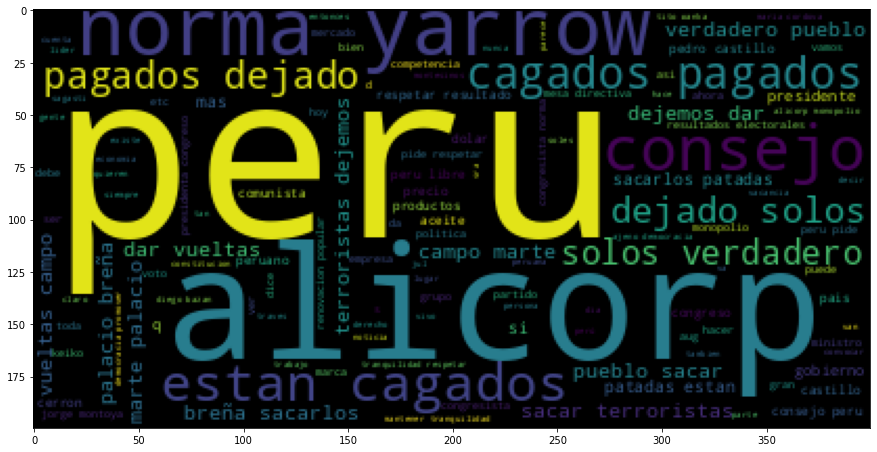

In [33]:
from wordcloud import WordCloud
wordcloud = WordCloud().generate(' '.join(df.Text_prep))
                                 
import matplotlib.pyplot as plt

plt.figure(figsize=[15,8])
plt.imshow(wordcloud)